## ResNet50 Transfer Learning: Data Augementation
### This notebook contains code to apply transfer learning to the ResNet50 model, with the goal of classifying facial emotions. This code will augment the dataset.

In [1]:
import numpy as np
import time
import pandas as pd
from matplotlib import pyplot as plt

# machine learning libraries and functions
import tensorflow as tf
import keras
from keras.models import Model
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, BatchNormalization, InputLayer
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# load input images and labels
inputs = np.load('input.npz')['arr_0']
label = np.load('labels.npz')['arr_0']

In [3]:
# split input images into training/testing
X_train, X_test, Y_train, Y_test = train_test_split(inputs, label, test_size=0.3, random_state=0)

# preprocesses test images for ResNet50
X_test = preprocess_input(X_test)

# create datagen to augment images
datagen = ImageDataGenerator(rotation_range=90,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.3,
                            horizontal_flip = True,
                            preprocessing_function=preprocess_input)

generator = datagen.flow(X_train, Y_train, batch_size=1, shuffle=False)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(9583, 128, 128, 3)
(9583, 8)
(4107, 128, 128, 3)
(4107, 8)


In [4]:
# load model for feature extraction
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))
#InceptionV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128,128,3))

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [5]:
# extract features from training data
feature_extraction = resnet_model.predict_generator(generator, steps=X_train.shape[0])

In [6]:
# save feature extraction tensor
np.savez_compressed('ResNet50_Feature_Extraction_Augmented', feature_extraction)

In [7]:
# load feature extraction tensor
feature_extraction = np.load('ResNet50_Feature_Extraction_Augmented.npz')['arr_0']

In [8]:
# get number of classes
NUM_CLASSES = label.shape[1]

# build trainable model
model = Sequential()
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [9]:
# compile model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
start_time = time.time()

EPOCHS = 500
STEPS_PER_EPOCH = 20
VALIDATION_STEPS = 1

# save weights with best validation accuracy
checkpoint_filepath = './ResNet50_Top_Data_Augmented.checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# stop training when validation accuracy stops improving
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.01,
    patience=25,
    mode='auto',
    restore_best_weights=True)

# train model
history = model.fit(
    x=feature_extraction, y=Y_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_split=0.2,
    shuffle=True,
    callbacks=[model_checkpoint_callback, early_stopping_callback])
  
print(f"Time consumed for {EPOCHS} epochs: {(time.time() - start_time )/60 // 0.01 * 0.01} mins")

Train on 7666 samples, validate on 1917 samples
Epoch 1/500
20/20 [==============================] - 14s 706ms/step - loss: 1.5440 - accuracy: 0.5775 - val_loss: 1.4287 - val_accuracy: 0.6286
Epoch 2/500
20/20 [==============================] - 13s 659ms/step - loss: 0.7943 - accuracy: 0.7935 - val_loss: 1.0425 - val_accuracy: 0.6870
Epoch 3/500
20/20 [==============================] - 14s 691ms/step - loss: 0.4393 - accuracy: 0.8840 - val_loss: 1.0235 - val_accuracy: 0.6813
Epoch 4/500
20/20 [==============================] - 13s 662ms/step - loss: 0.2557 - accuracy: 0.9307 - val_loss: 0.8823 - val_accuracy: 0.7053
Epoch 5/500
20/20 [==============================] - 13s 656ms/step - loss: 0.1585 - accuracy: 0.9594 - val_loss: 0.9042 - val_accuracy: 0.6922
Epoch 6/500
20/20 [==============================] - 13s 646ms/step - loss: 0.1257 - accuracy: 0.9641 - val_loss: 0.8990 - val_accuracy: 0.6907
Epoch 7/500
20/20 [==============================] - 13s 654ms/step - loss: 0.0568 - acc

In [11]:
# load weights with best validation accuracy
model.load_weights(checkpoint_filepath)

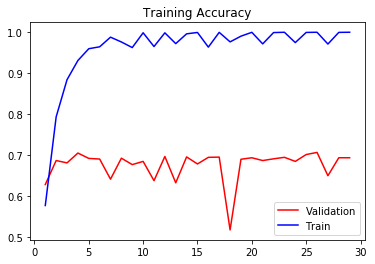

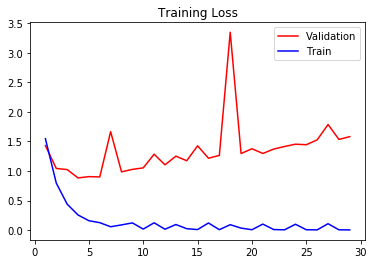

In [12]:
# visualize training statistics
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, val_acc,'r', label = 'Validation')
plt.plot(epochs, acc,'b', label = 'Train')
plt.title("Training Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, val_loss,'r', label = 'Validation')
plt.plot(epochs,loss,'b', label = 'Train')
plt.title("Training Loss")

plt.legend()
plt.show()

In [13]:
# combine ResNet50 base model with trained layers
out = model(resnet_model.outputs)
transfer_model = Model(inputs=resnet_model.inputs, outputs=out)

transfer_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# test full model
evaluation = transfer_model.evaluate(x = X_test, y = Y_test)

4107/4107 [==============================] - 426s 104ms/step


In [15]:
print(transfer_model.metrics_names)
print(evaluation)

['loss', 'accuracy']
[1.4361174368048515, 0.7363038659095764]
